In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
import seaborn as sns
import arviz as az
import xarray as xr
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
def generate():
    group_list = ["one", "two", "three", "four", "five"]
    trials_per_group = 20
    group_intercepts = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list)) * -0.5
    group_mx = group_intercepts * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list

In [4]:
data, group_list = generate()

In [5]:
print(group_list)

['one', 'two', 'three', 'four', 'five']


In [6]:
display(data)

,group,group_idx,x,y
0,one,0,-0.692745,0.750369
1,one,0,0.737275,-0.709225
2,one,0,0.293192,0.123805
3,one,0,0.592633,1.153426
4,one,0,-0.243610,-0.996081
...,...,...,...,...
95,five,4,-4.280233,-1.424379
96,five,4,-2.602842,-1.193167
97,five,4,-4.258334,-1.682318
98,five,4,-3.164555,-1.675854


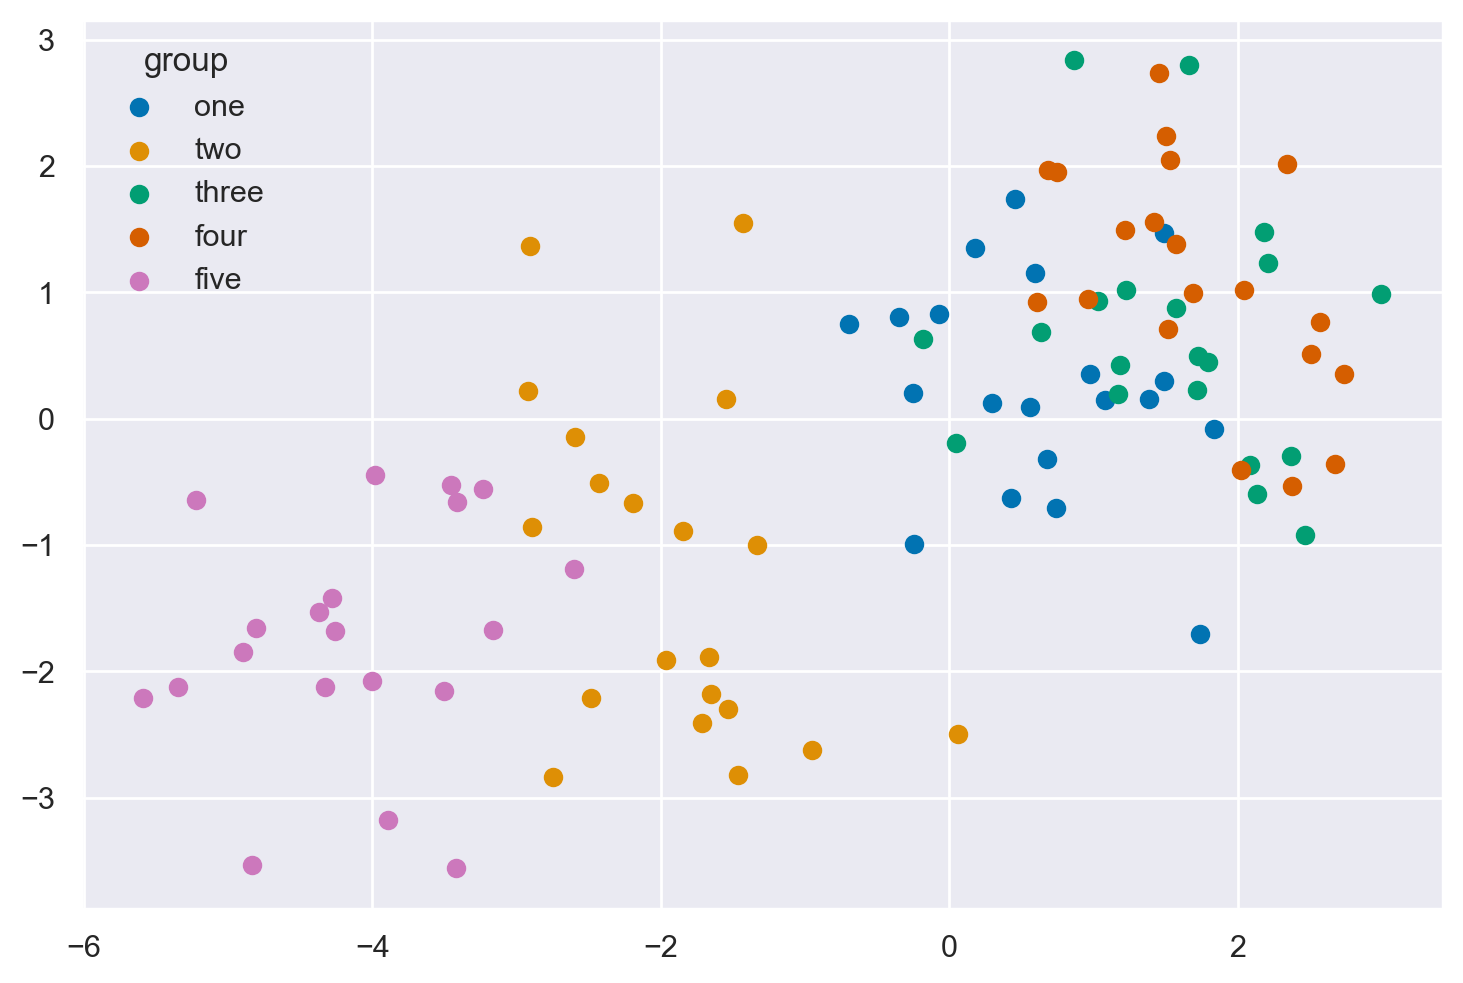

In [7]:
for i, group in enumerate(group_list):
    plt.scatter(
        data.x[data.group_idx == i],
        data.y[data.group_idx == i],
        color=f"C{i}",
        label=f"{group}",
    )
plt.legend(title="group");

In [8]:
with pm.Model() as linear_regression:
    sigma = pm.HalfCauchy("sigma", beta=2)
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    x = pm.MutableData("x", data.x, dims="obs_id")
    μ = pm.Deterministic("μ", β0 + β1 * x, dims="obs_id")
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

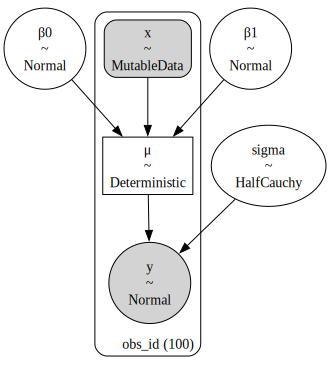

In [9]:
pm.model_to_graphviz(linear_regression)

In [10]:
with linear_regression:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:01.099683


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1479.35it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1480.53it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1481.91it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1481.94it/s]


Sampling time = 0:00:01.585789


Transforming variables...


Transformation time = 0:00:00.107603


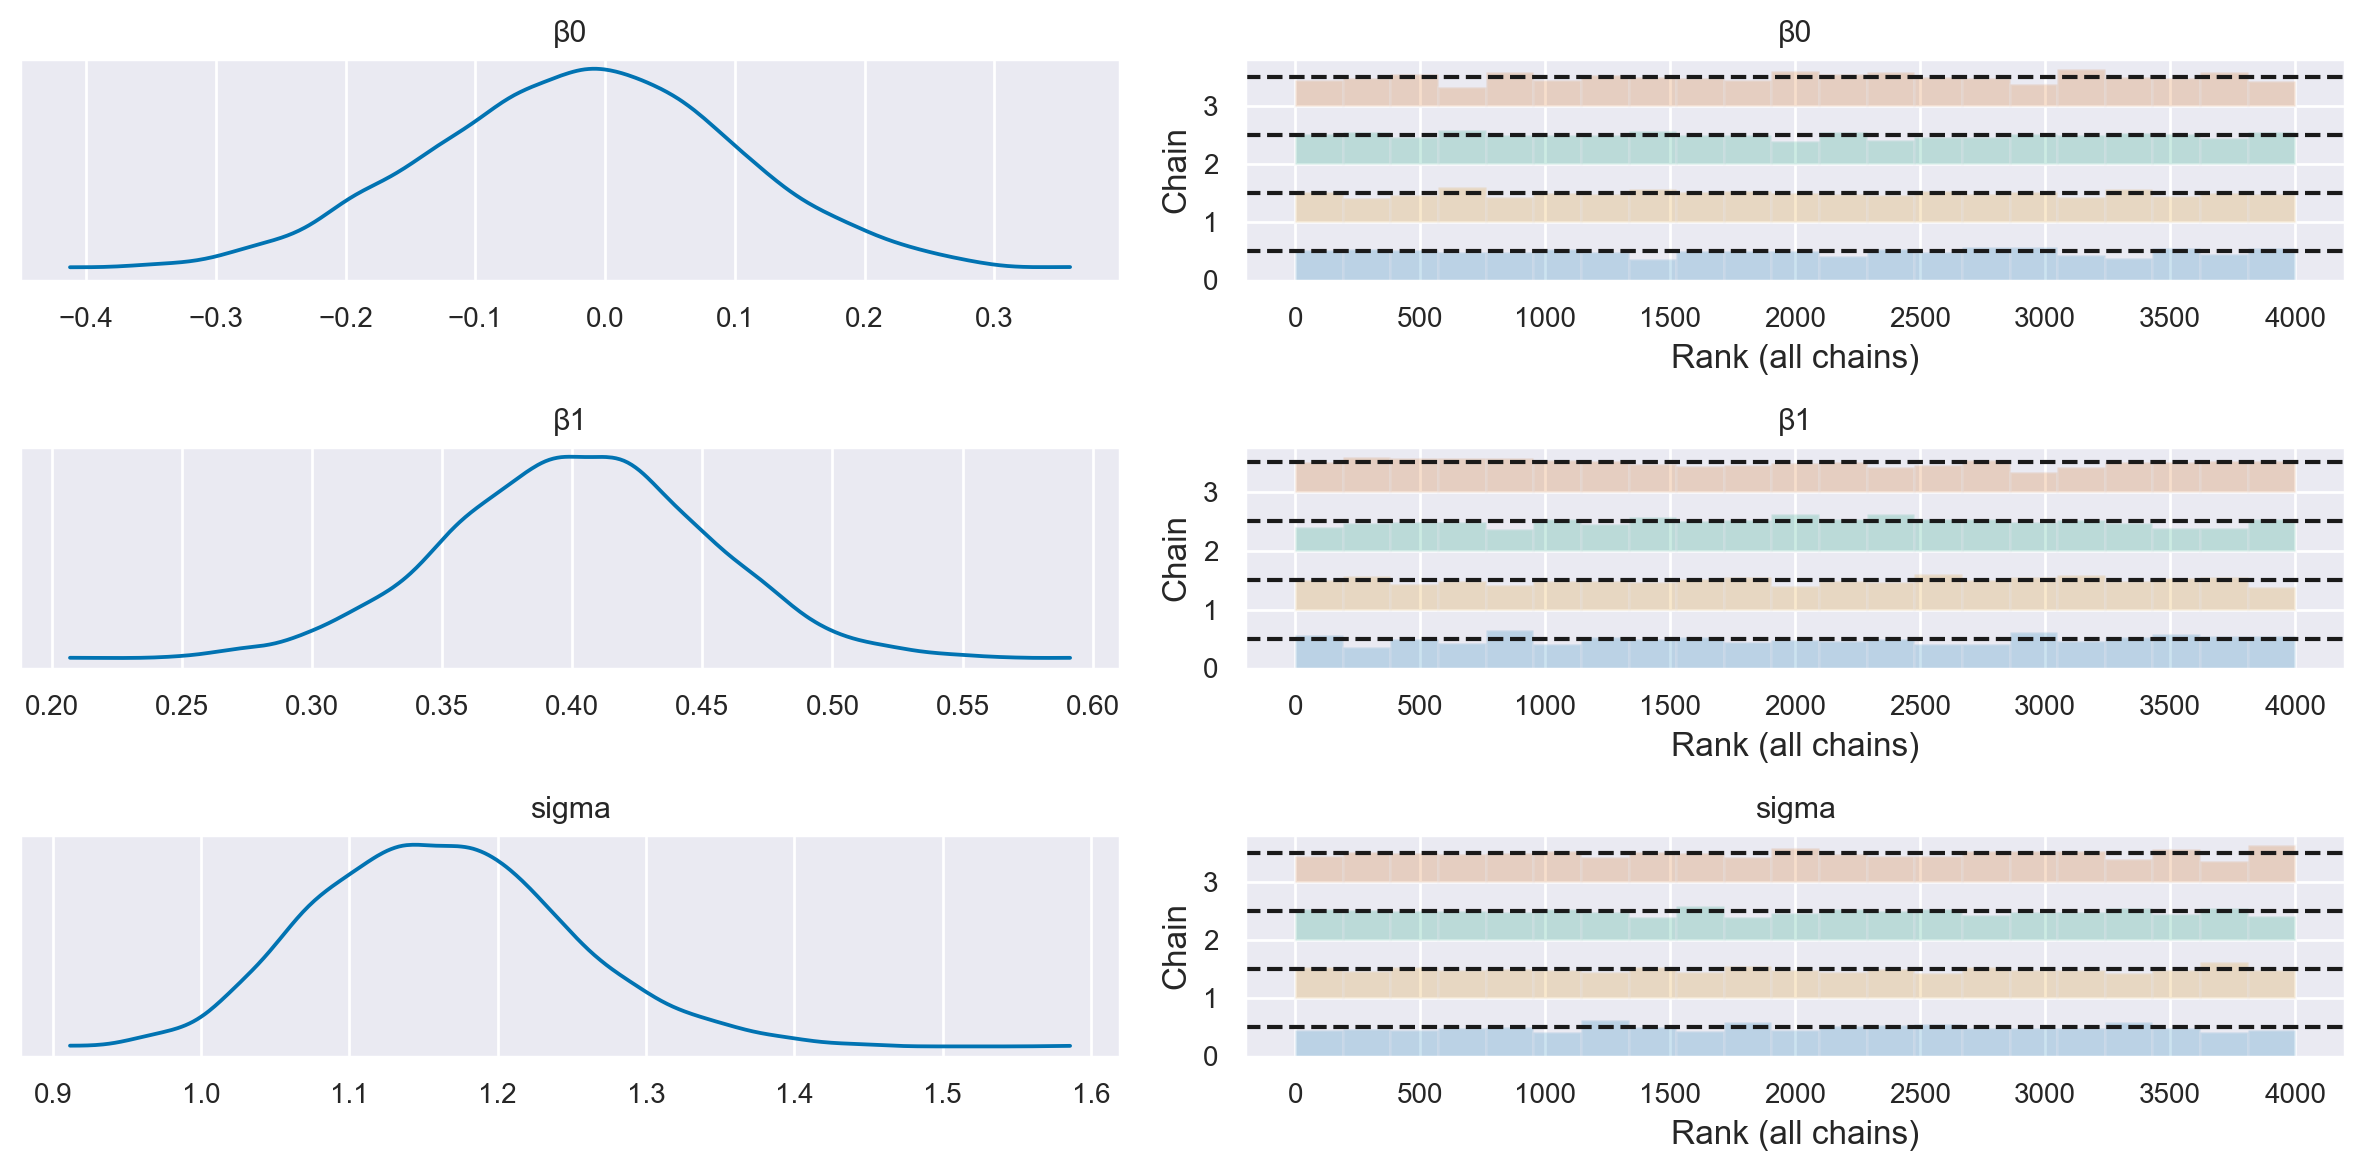

In [11]:
az.plot_trace(
    idata,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    combined=True,
    divergences="bottom",
)
plt.tight_layout()

In [12]:
# posterior prediction for these x values
xi = np.linspace(data.x.min(), data.x.max(), 20)

# do posterior predictive inference
with linear_regression:
    pm.set_data({"x": xi})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["y", "μ"]))

Sampling: [y]


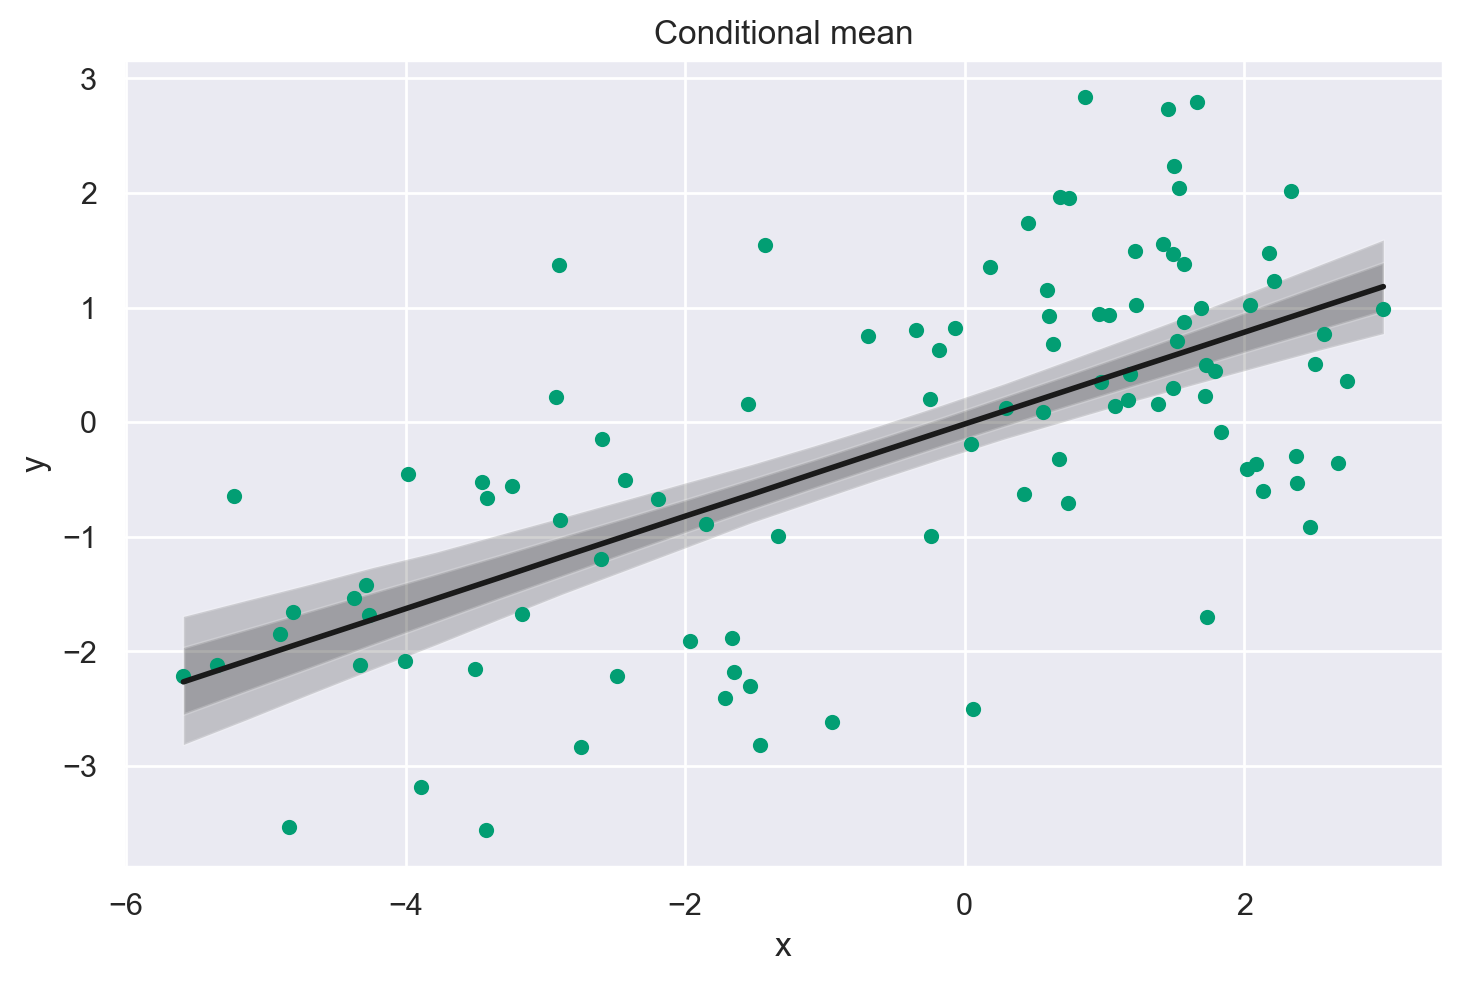

In [13]:
post = az.extract(idata)

xi = xr.DataArray(np.linspace(np.min(data['x']), np.max(data['x']), 20), dims=["x_plot"])
y = post.β0 + post.β1 * xi
region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")

fig, ax = plt.subplots(1, 1)

ax.fill_between(
    xi, region.sel(quantile=0.025), region.sel(quantile=0.975), alpha=0.2, color="k", edgecolor="w"
)
ax.fill_between(
    xi, region.sel(quantile=0.15), region.sel(quantile=0.85), alpha=0.2, color="k", edgecolor="w"
)

# Plotting the conditional mean
ax.plot(xi, region.sel(quantile=0.5), "k", linewidth=2)

# Plotting the data points
ax.scatter(data['x'], data['y'], color='C2', s=20, label='Data points')

# Formatting
ax.set(xlabel="x", ylabel="y", title="Conditional mean")

plt.show()  # Add this line to actually show the plot

In [14]:
beta_0 = idata.posterior.β0.mean().values
print(beta_0)

-0.019009915991585066


In [15]:
beta_1 = idata.posterior.β1.mean().values
print(beta_1)

0.4014295351381203


In [16]:
xi = np.linspace(np.min(data["x"]), np.max(data["x"]), 20)
xi

array([-5.58940481, -5.13754963, -4.68569444, -4.23383926, -3.78198407,
       -3.33012889, -2.8782737 , -2.42641852, -1.97456333, -1.52270815,
       -1.07085296, -0.61899778, -0.16714259,  0.28471259,  0.73656778,
        1.18842296,  1.64027815,  2.09213333,  2.54398852,  2.9958437 ])

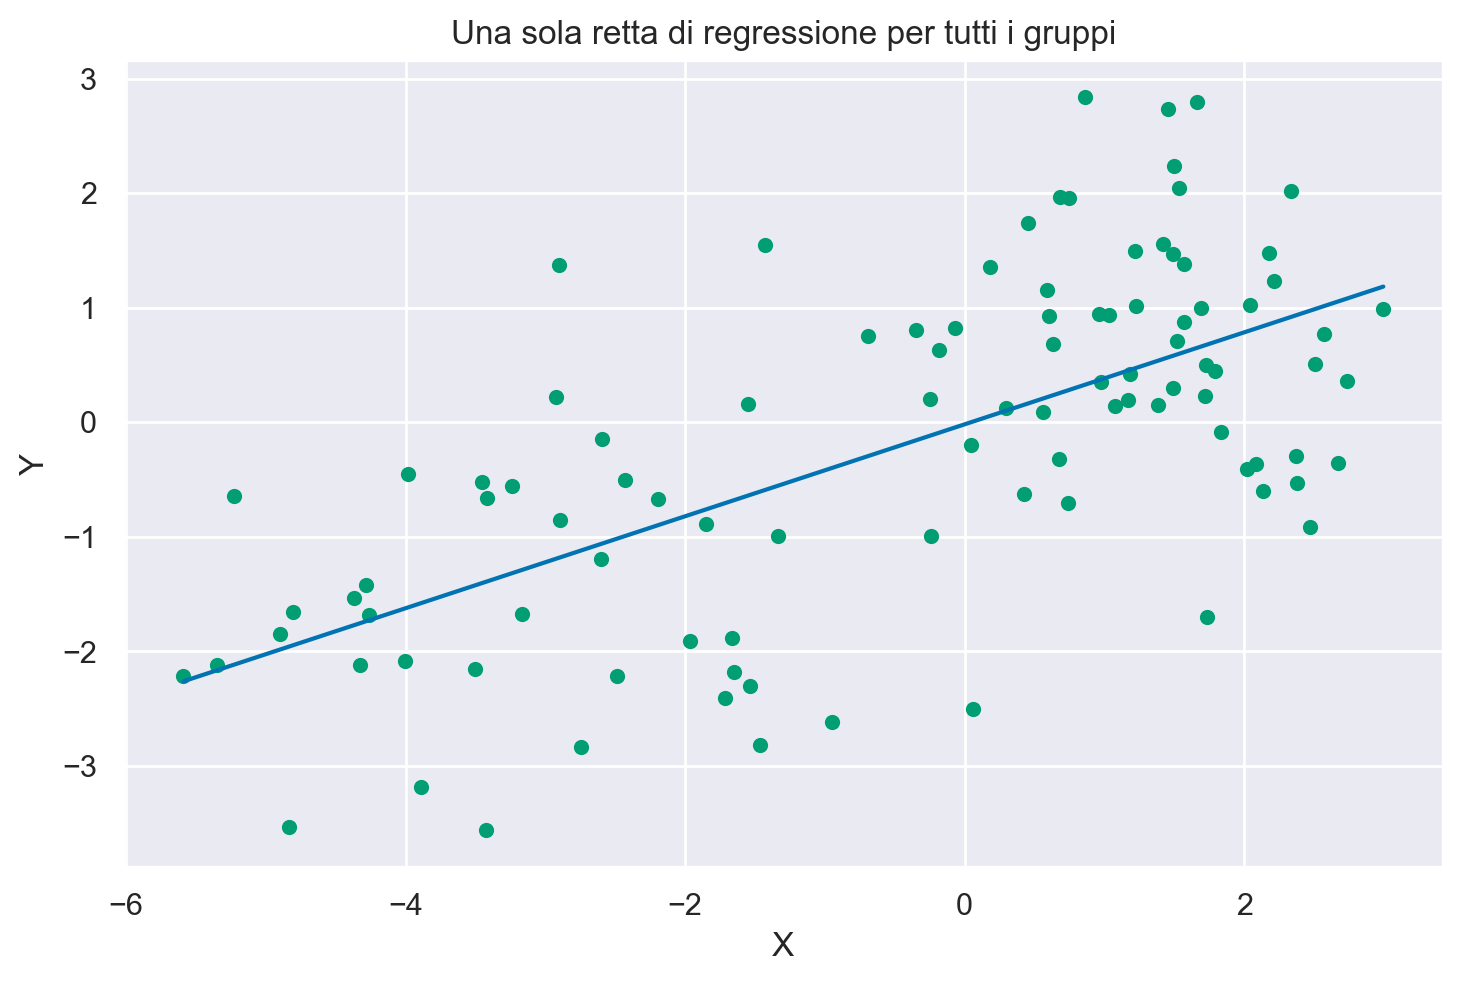

In [17]:
# Genera la linea di regressione utilizzando l'equazione della retta
y_pred = beta_0 + beta_1 * xi

# Visualizza la linea di regressione
plt.plot(xi, y_pred)
plt.scatter(data['x'], data['y'], color='C2', s=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Una sola retta di regressione per tutti i gruppi')
plt.show()

In [18]:
az.summary(idata, var_names="β1")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β1,0.401,0.05,0.303,0.491,0.001,0.001,3327.0,2889.0,1.0


In [19]:
coords = {"group": group_list}

with pm.Model(coords=coords) as ind_slope_intercept:
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=2, dims="group")
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

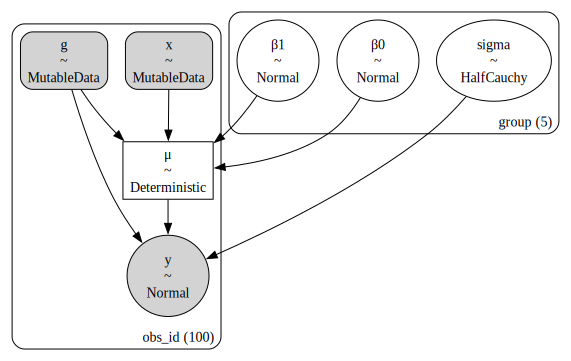

In [20]:
pm.model_to_graphviz(ind_slope_intercept)

In [21]:
with ind_slope_intercept:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:00.834510


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:  55%|████████████████████████████                       | 1100/2000 [00:01<00:00, 10822.21it/s]

Running chain 3:  55%|████████████████████████████                       | 1100/2000 [00:01<00:00, 10466.92it/s]

Running chain 2:  55%|████████████████████████████                       | 1100/2000 [00:01<00:00, 10401.23it/s]

Running chain 0:  55%|████████████████████████████▌                       | 1100/2000 [00:01<00:00, 9866.02it/s]

Running chain 0:  95%|█████████████████████████████████████████████████▍  | 1900/2000 [00:01<00:00, 8626.52it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1149.36it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1150.25it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1151.06it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1151.87it/s]


Sampling time = 0:00:01.840969


Transforming variables...


Transformation time = 0:00:00.107463


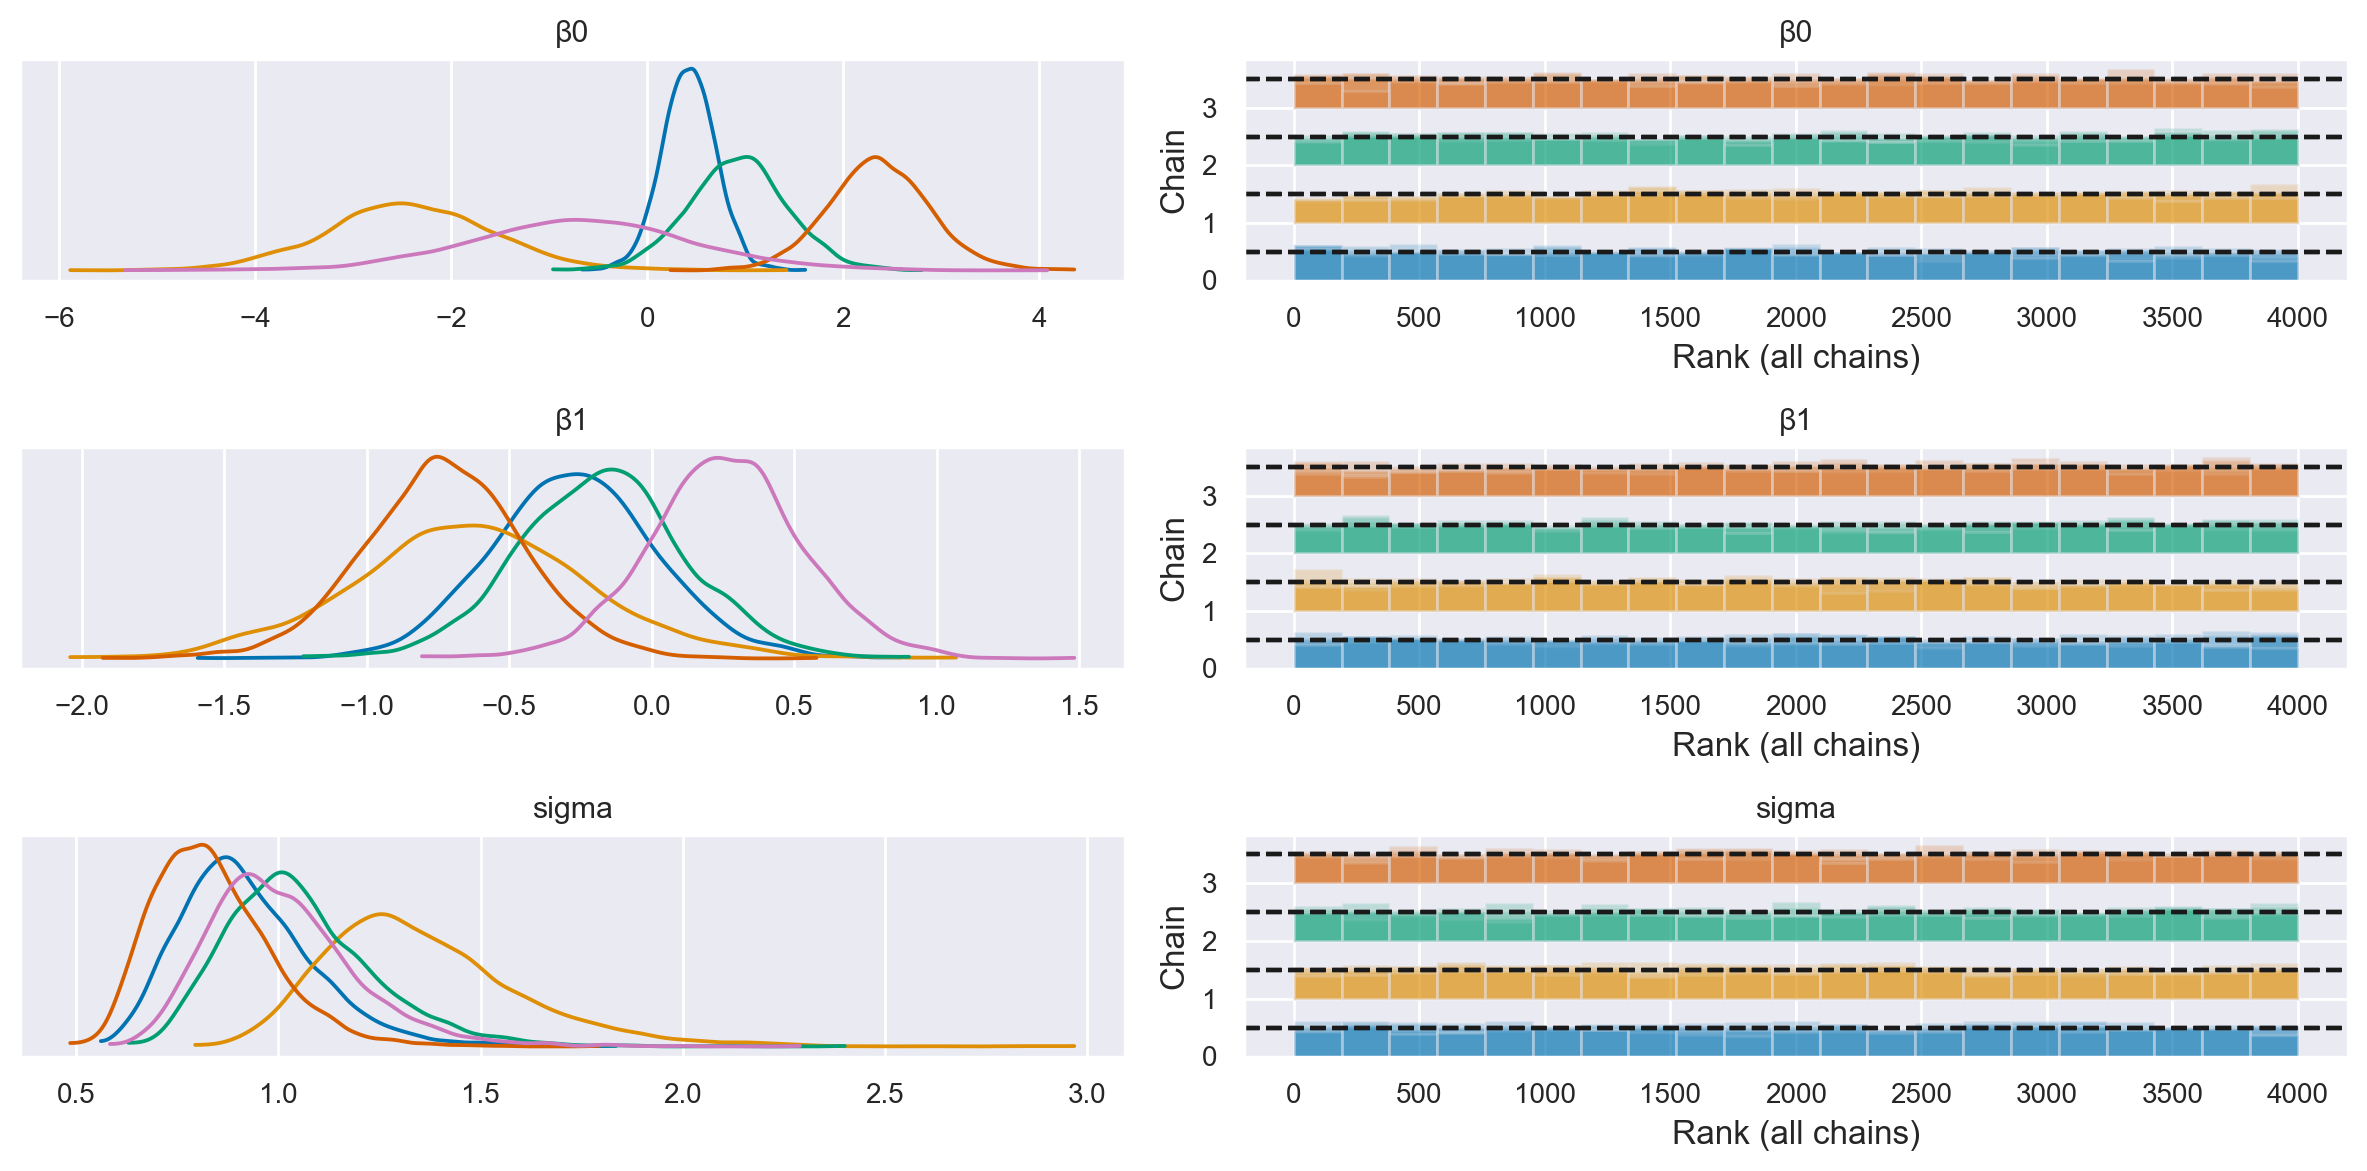

In [22]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

In [23]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with ind_slope_intercept:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"]))

Sampling: [y]


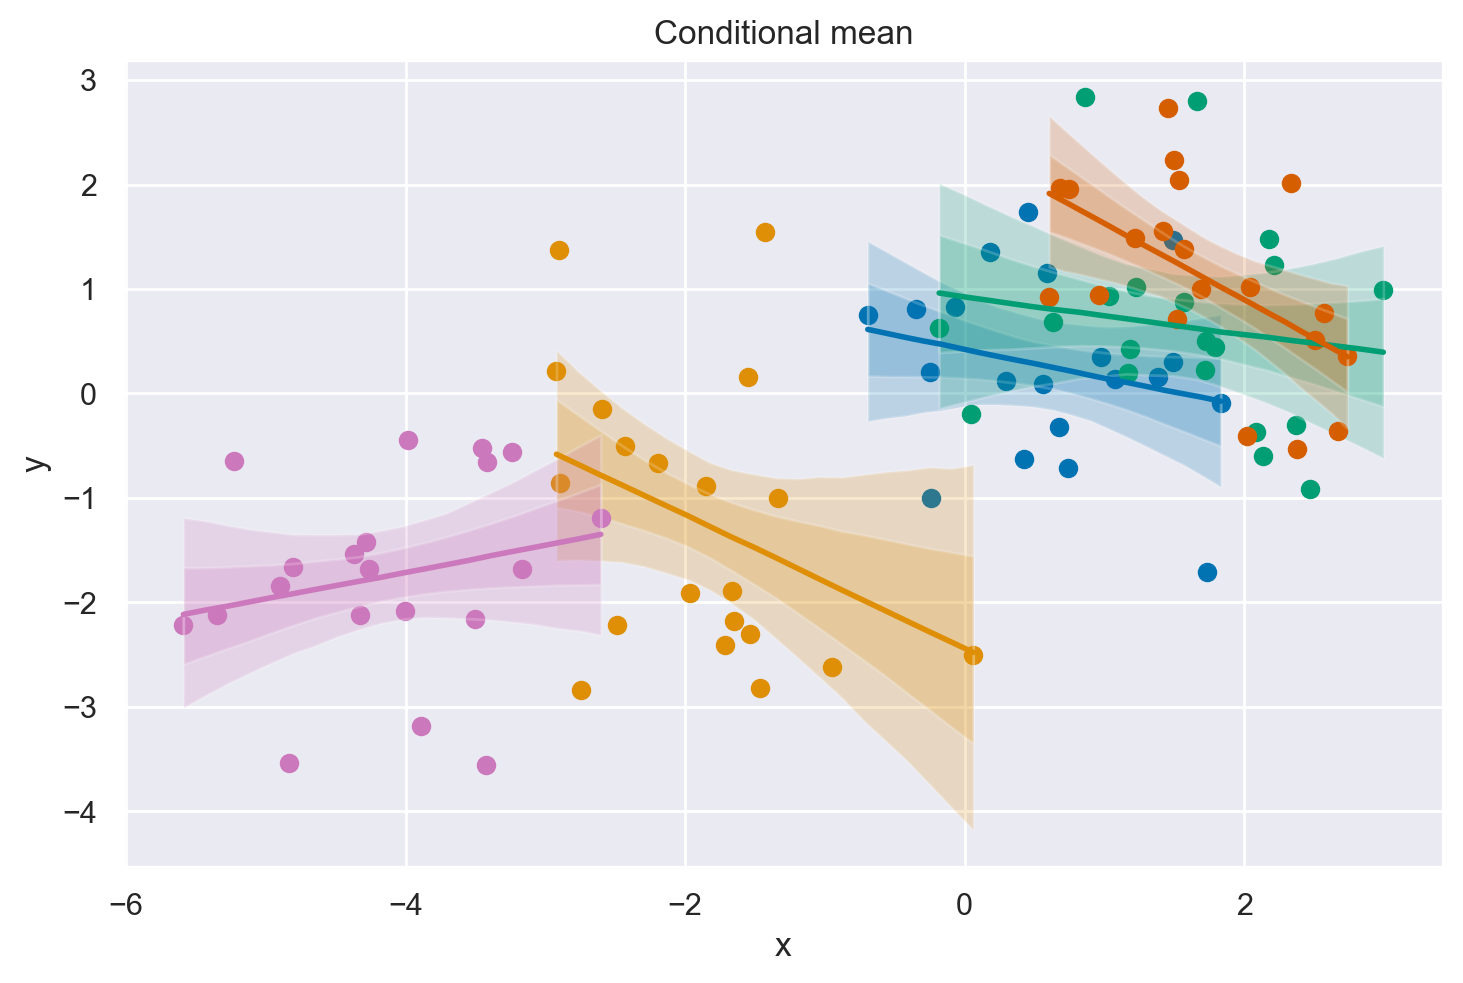

In [24]:
def get_ppy_for_group(group_list, group):
    """Get posterior predictive outcomes for observations from a given group"""
    return idata.posterior_predictive.y.data[:, :, group_list == group]


fig, ax = plt.subplots(1, 1)

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax.scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax.fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax.fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax.plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax.set(xlabel="x", ylabel="y", title="Conditional mean")


In [25]:
non_centered = False

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    if non_centered:
        β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
        β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
        β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
        β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")
    else:
        β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
        β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

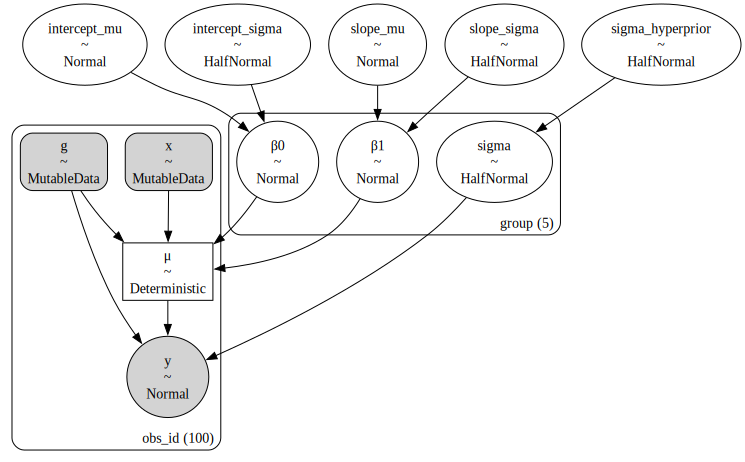

In [26]:
pm.model_to_graphviz(hierarchical)

In [27]:
with hierarchical:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=5000, target_accept=0.99)

Compiling...


Compilation time = 0:00:01.146541


Sampling...


  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/6000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/6000 [00:02<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/6000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/6000 [00:02<?, ?it/s]

Running chain 3:   5%|██▋                                                  | 300/6000 [00:02<00:02, 2830.30it/s]

Running chain 1:   5%|██▋                                                  | 300/6000 [00:02<00:02, 2483.46it/s]

Running chain 2:  10%|█████▎                                               | 600/6000 [00:02<00:01, 3672.19it/s]

Running chain 0:   5%|██▋                                                  | 300/6000 [00:02<00:03, 1661.28it/s]

Running chain 3:  15%|███████▉                                             | 900/6000 [00:02<00:01, 3658.59it/s]

Running chain 1:  15%|███████▉                                             | 900/6000 [00:02<00:01, 3353.48it/s]

Running chain 2:  20%|██████████▍                                         | 1200/6000 [00:02<00:01, 3777.59it/s]

Running chain 0:  15%|███████▉                                             | 900/6000 [00:02<00:01, 2946.76it/s]

Running chain 1:  25%|█████████████                                       | 1500/6000 [00:02<00:01, 3954.09it/s]

Running chain 3:  25%|█████████████                                       | 1500/6000 [00:02<00:01, 3797.00it/s]

Running chain 2:  25%|█████████████                                       | 1500/6000 [00:02<00:01, 3481.30it/s]

Running chain 0:  25%|█████████████                                       | 1500/6000 [00:02<00:01, 3700.46it/s]

Running chain 1:  35%|██████████████████▏                                 | 2100/6000 [00:02<00:00, 3958.41it/s]

Running chain 2:  35%|██████████████████▏                                 | 2100/6000 [00:02<00:01, 3780.87it/s]

Running chain 3:  35%|██████████████████▏                                 | 2100/6000 [00:02<00:01, 3730.60it/s]

Running chain 0:  35%|██████████████████▏                                 | 2100/6000 [00:02<00:00, 4156.27it/s]

Running chain 1:  45%|███████████████████████▍                            | 2700/6000 [00:02<00:00, 4303.26it/s]

Running chain 2:  45%|███████████████████████▍                            | 2700/6000 [00:02<00:00, 3949.51it/s]

Running chain 0:  45%|███████████████████████▍                            | 2700/6000 [00:02<00:00, 4227.00it/s]

Running chain 3:  45%|███████████████████████▍                            | 2700/6000 [00:02<00:00, 3870.39it/s]

Running chain 1:  55%|████████████████████████████▌                       | 3300/6000 [00:02<00:00, 4465.51it/s]

Running chain 3:  55%|████████████████████████████▌                       | 3300/6000 [00:02<00:00, 4050.94it/s]

Running chain 0:  55%|████████████████████████████▌                       | 3300/6000 [00:03<00:00, 4066.94it/s]

Running chain 2:  55%|████████████████████████████▌                       | 3300/6000 [00:03<00:00, 3802.67it/s]

Running chain 1:  65%|█████████████████████████████████▊                  | 3900/6000 [00:03<00:00, 4601.58it/s]

Running chain 0:  65%|█████████████████████████████████▊                  | 3900/6000 [00:03<00:00, 4074.03it/s]

Running chain 2:  65%|█████████████████████████████████▊                  | 3900/6000 [00:03<00:00, 3732.45it/s]

Running chain 1:  75%|███████████████████████████████████████             | 4500/6000 [00:03<00:00, 4447.06it/s]

Running chain 3:  65%|█████████████████████████████████▊                  | 3900/6000 [00:03<00:00, 3431.88it/s]

Running chain 0:  75%|███████████████████████████████████████             | 4500/6000 [00:03<00:00, 4088.99it/s]

Running chain 2:  75%|███████████████████████████████████████             | 4500/6000 [00:03<00:00, 3510.70it/s]

Running chain 1:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:03<00:00, 3867.89it/s]

Running chain 1:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:03<00:00, 4289.75it/s]

Running chain 0:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:03<00:00, 3527.28it/s]

Running chain 3:  75%|███████████████████████████████████████             | 4500/6000 [00:03<00:00, 2694.32it/s]

Running chain 0:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:03<00:00, 3843.22it/s]

Running chain 2:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:03<00:00, 2914.65it/s]

Running chain 3:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:03<00:00, 3081.18it/s]

Running chain 2:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:03<00:00, 3411.50it/s]

Running chain 3:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:03<00:00, 3560.89it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1561.91it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1562.29it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1562.80it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1563.27it/s]

Sampling time = 0:00:03.962050


Transforming variables...


Transformation time = 0:00:00.096089


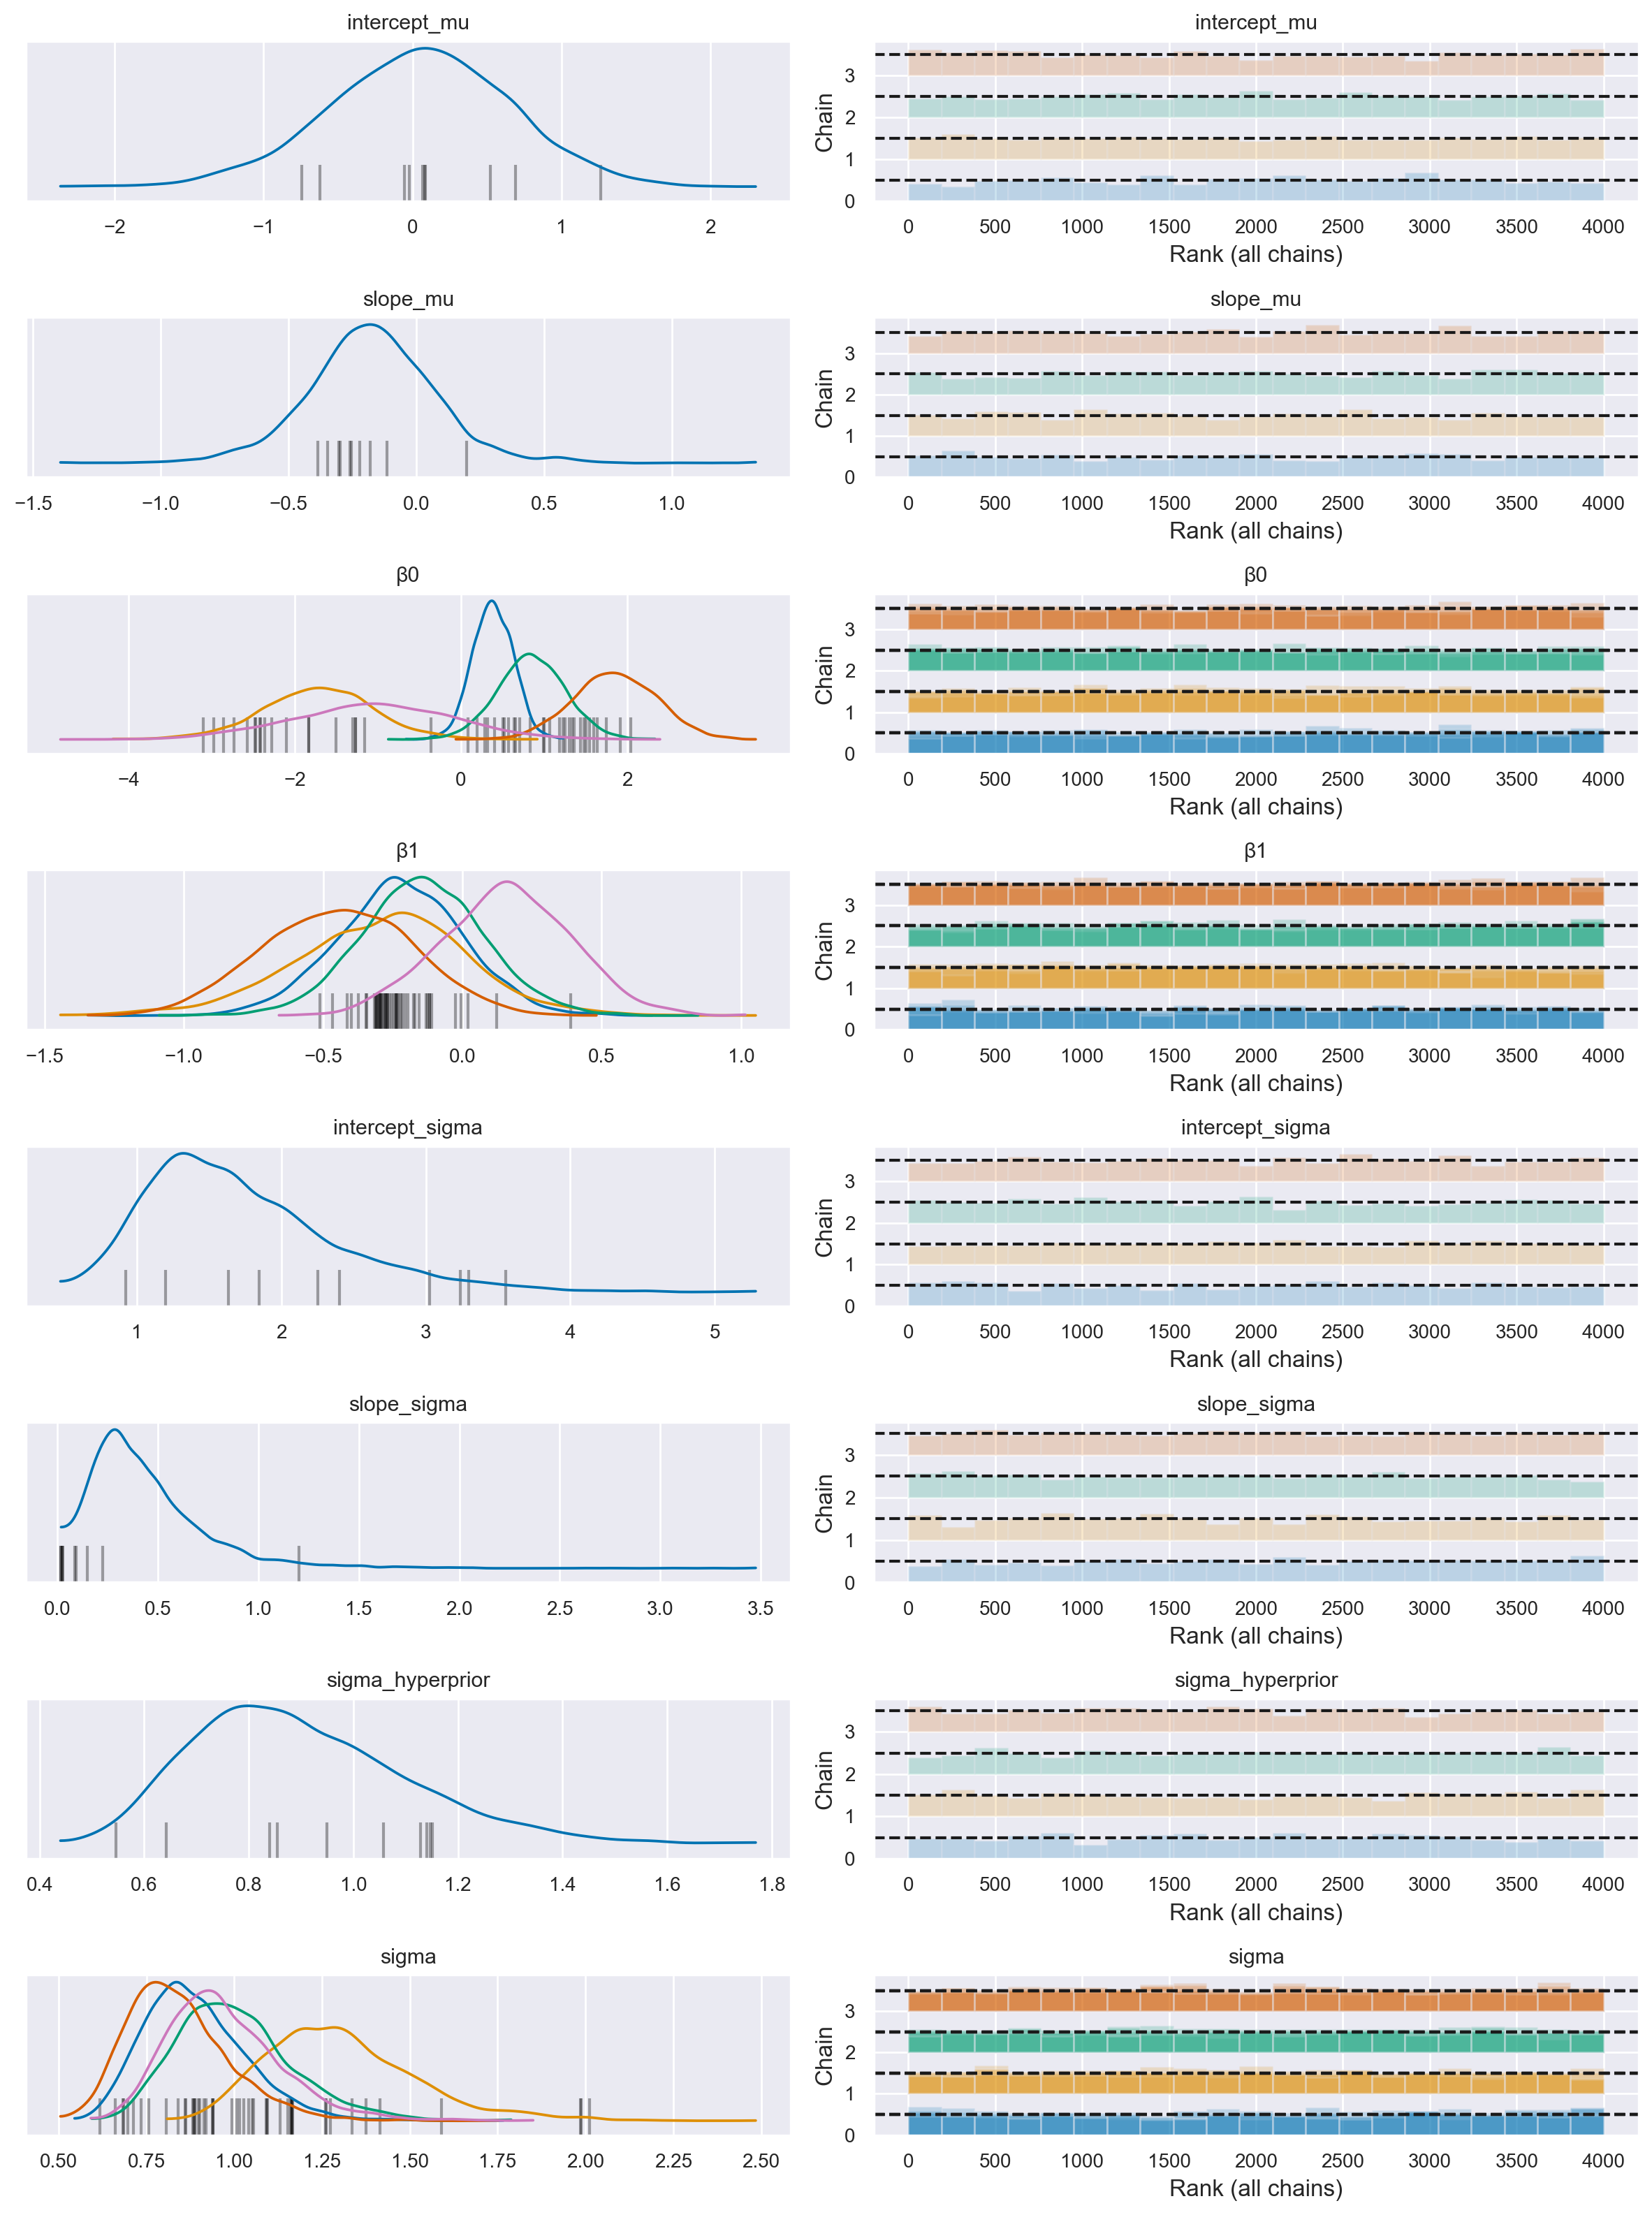

In [28]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

In [29]:
non_centered = True

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    if non_centered:
        β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
        β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
        β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
        β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")
    else:
        β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
        β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

In [30]:
with hierarchical:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=5000, target_accept=0.99)

Compiling...


Compilation time = 0:00:00.955159


Sampling...


  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/6000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/6000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/6000 [00:02<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/6000 [00:02<?, ?it/s]

Running chain 1:   5%|██▋                                                  | 300/6000 [00:02<00:03, 1747.70it/s]

Running chain 2:   5%|██▋                                                  | 300/6000 [00:02<00:03, 1696.48it/s]

Running chain 0:   5%|██▋                                                  | 300/6000 [00:02<00:03, 1599.42it/s]

Running chain 3:   5%|██▋                                                  | 300/6000 [00:02<00:04, 1359.52it/s]

Running chain 1:  10%|█████▎                                               | 600/6000 [00:02<00:02, 2164.49it/s]

Running chain 0:  10%|█████▎                                               | 600/6000 [00:02<00:02, 2010.76it/s]

Running chain 2:  10%|█████▎                                               | 600/6000 [00:02<00:02, 1938.96it/s]

Running chain 3:  10%|█████▎                                               | 600/6000 [00:02<00:02, 1820.38it/s]

Running chain 1:  15%|███████▉                                             | 900/6000 [00:02<00:02, 2237.20it/s]

Running chain 0:  15%|███████▉                                             | 900/6000 [00:02<00:02, 2111.52it/s]

Running chain 3:  15%|███████▉                                             | 900/6000 [00:02<00:02, 2025.03it/s]

Running chain 2:  15%|███████▉                                             | 900/6000 [00:02<00:02, 1904.09it/s]

Running chain 1:  20%|██████████▍                                         | 1200/6000 [00:02<00:02, 2372.53it/s]

Running chain 0:  20%|██████████▍                                         | 1200/6000 [00:02<00:02, 2331.66it/s]

Running chain 3:  20%|██████████▍                                         | 1200/6000 [00:02<00:02, 2210.26it/s]

Running chain 2:  20%|██████████▍                                         | 1200/6000 [00:02<00:02, 2064.71it/s]

Running chain 1:  25%|█████████████                                       | 1500/6000 [00:02<00:01, 2435.70it/s]

Running chain 0:  25%|█████████████                                       | 1500/6000 [00:02<00:01, 2439.78it/s]

Running chain 3:  25%|█████████████                                       | 1500/6000 [00:02<00:02, 2129.91it/s]

Running chain 2:  25%|█████████████                                       | 1500/6000 [00:02<00:02, 2034.36it/s]

Running chain 1:  30%|███████████████▌                                    | 1800/6000 [00:02<00:01, 2414.07it/s]

Running chain 0:  30%|███████████████▌                                    | 1800/6000 [00:02<00:01, 2366.86it/s]

Running chain 1:  35%|██████████████████▏                                 | 2100/6000 [00:03<00:01, 2489.47it/s]

Running chain 3:  30%|███████████████▌                                    | 1800/6000 [00:03<00:02, 2075.46it/s]

Running chain 2:  30%|███████████████▌                                    | 1800/6000 [00:03<00:02, 2035.19it/s]

Running chain 0:  35%|██████████████████▏                                 | 2100/6000 [00:03<00:01, 2287.21it/s]

Running chain 1:  40%|████████████████████▊                               | 2400/6000 [00:03<00:01, 2482.17it/s]

Running chain 3:  35%|██████████████████▏                                 | 2100/6000 [00:03<00:01, 2142.25it/s]

Running chain 2:  35%|██████████████████▏                                 | 2100/6000 [00:03<00:01, 2048.12it/s]

Running chain 0:  40%|████████████████████▊                               | 2400/6000 [00:03<00:01, 2329.24it/s]

Running chain 1:  45%|███████████████████████▍                            | 2700/6000 [00:03<00:01, 2453.31it/s]

Running chain 3:  40%|████████████████████▊                               | 2400/6000 [00:03<00:01, 2258.85it/s]

Running chain 2:  40%|████████████████████▊                               | 2400/6000 [00:03<00:01, 2150.28it/s]

Running chain 0:  45%|███████████████████████▍                            | 2700/6000 [00:03<00:01, 2210.35it/s]

Running chain 1:  50%|██████████████████████████                          | 3000/6000 [00:03<00:01, 2455.18it/s]

Running chain 3:  45%|███████████████████████▍                            | 2700/6000 [00:03<00:01, 2316.55it/s]

Running chain 2:  45%|███████████████████████▍                            | 2700/6000 [00:03<00:01, 2202.33it/s]

Running chain 0:  50%|██████████████████████████                          | 3000/6000 [00:03<00:01, 2186.50it/s]

Running chain 1:  55%|████████████████████████████▌                       | 3300/6000 [00:03<00:01, 2416.92it/s]

Running chain 3:  50%|██████████████████████████                          | 3000/6000 [00:03<00:01, 2271.42it/s]

Running chain 2:  50%|██████████████████████████                          | 3000/6000 [00:03<00:01, 2239.83it/s]

Running chain 0:  55%|████████████████████████████▌                       | 3300/6000 [00:03<00:01, 2210.21it/s]

Running chain 1:  60%|███████████████████████████████▏                    | 3600/6000 [00:03<00:00, 2431.96it/s]

Running chain 3:  55%|████████████████████████████▌                       | 3300/6000 [00:03<00:01, 2255.05it/s]

Running chain 2:  55%|████████████████████████████▌                       | 3300/6000 [00:03<00:01, 2258.61it/s]

Running chain 0:  60%|███████████████████████████████▏                    | 3600/6000 [00:03<00:01, 2142.13it/s]

Running chain 1:  65%|█████████████████████████████████▊                  | 3900/6000 [00:03<00:00, 2357.40it/s]

Running chain 3:  60%|███████████████████████████████▏                    | 3600/6000 [00:03<00:01, 2207.17it/s]

Running chain 2:  60%|███████████████████████████████▏                    | 3600/6000 [00:03<00:01, 2309.59it/s]

Running chain 0:  65%|█████████████████████████████████▊                  | 3900/6000 [00:03<00:00, 2169.32it/s]

Running chain 1:  70%|████████████████████████████████████▍               | 4200/6000 [00:03<00:00, 2349.34it/s]

Running chain 3:  65%|█████████████████████████████████▊                  | 3900/6000 [00:03<00:00, 2175.37it/s]

Running chain 2:  65%|█████████████████████████████████▊                  | 3900/6000 [00:03<00:00, 2244.32it/s]

Running chain 1:  75%|███████████████████████████████████████             | 4500/6000 [00:04<00:00, 2315.01it/s]

Running chain 0:  70%|████████████████████████████████████▍               | 4200/6000 [00:04<00:00, 2075.70it/s]

Running chain 3:  70%|████████████████████████████████████▍               | 4200/6000 [00:04<00:00, 2222.32it/s]

Running chain 2:  70%|████████████████████████████████████▍               | 4200/6000 [00:04<00:00, 2196.81it/s]

Running chain 1:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:04<00:00, 2353.79it/s]

Running chain 0:  75%|███████████████████████████████████████             | 4500/6000 [00:04<00:00, 2077.65it/s]

Running chain 2:  75%|███████████████████████████████████████             | 4500/6000 [00:04<00:00, 2284.76it/s]

Running chain 3:  75%|███████████████████████████████████████             | 4500/6000 [00:04<00:00, 2176.53it/s]

Running chain 1:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:04<00:00, 2293.55it/s]

Running chain 2:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:04<00:00, 2199.35it/s]

Running chain 3:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:04<00:00, 2156.48it/s]

Running chain 0:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:04<00:00, 1973.70it/s]

Running chain 1:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:04<00:00, 2258.68it/s]

Running chain 2:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:04<00:00, 2145.02it/s]

Running chain 0:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:04<00:00, 1999.50it/s]

Running chain 3:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:04<00:00, 2093.04it/s]

Running chain 1:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:04<00:00, 2230.38it/s]

Running chain 3:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:04<00:00, 2195.60it/s]

Running chain 2:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:04<00:00, 2103.34it/s]

Running chain 0:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:04<00:00, 2022.82it/s]

Running chain 1: 100%|████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 2194.92it/s]

Running chain 3:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:04<00:00, 2201.90it/s]

Running chain 2:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:04<00:00, 2050.88it/s]

Running chain 0:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:04<00:00, 1980.88it/s]

Running chain 3: 100%|████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 2251.19it/s]

Running chain 2: 100%|████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 2042.31it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 2007.22it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1208.66it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1208.85it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1209.11it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1209.35it/s]

Sampling time = 0:00:05.088390


Transforming variables...


Transformation time = 0:00:00.117098


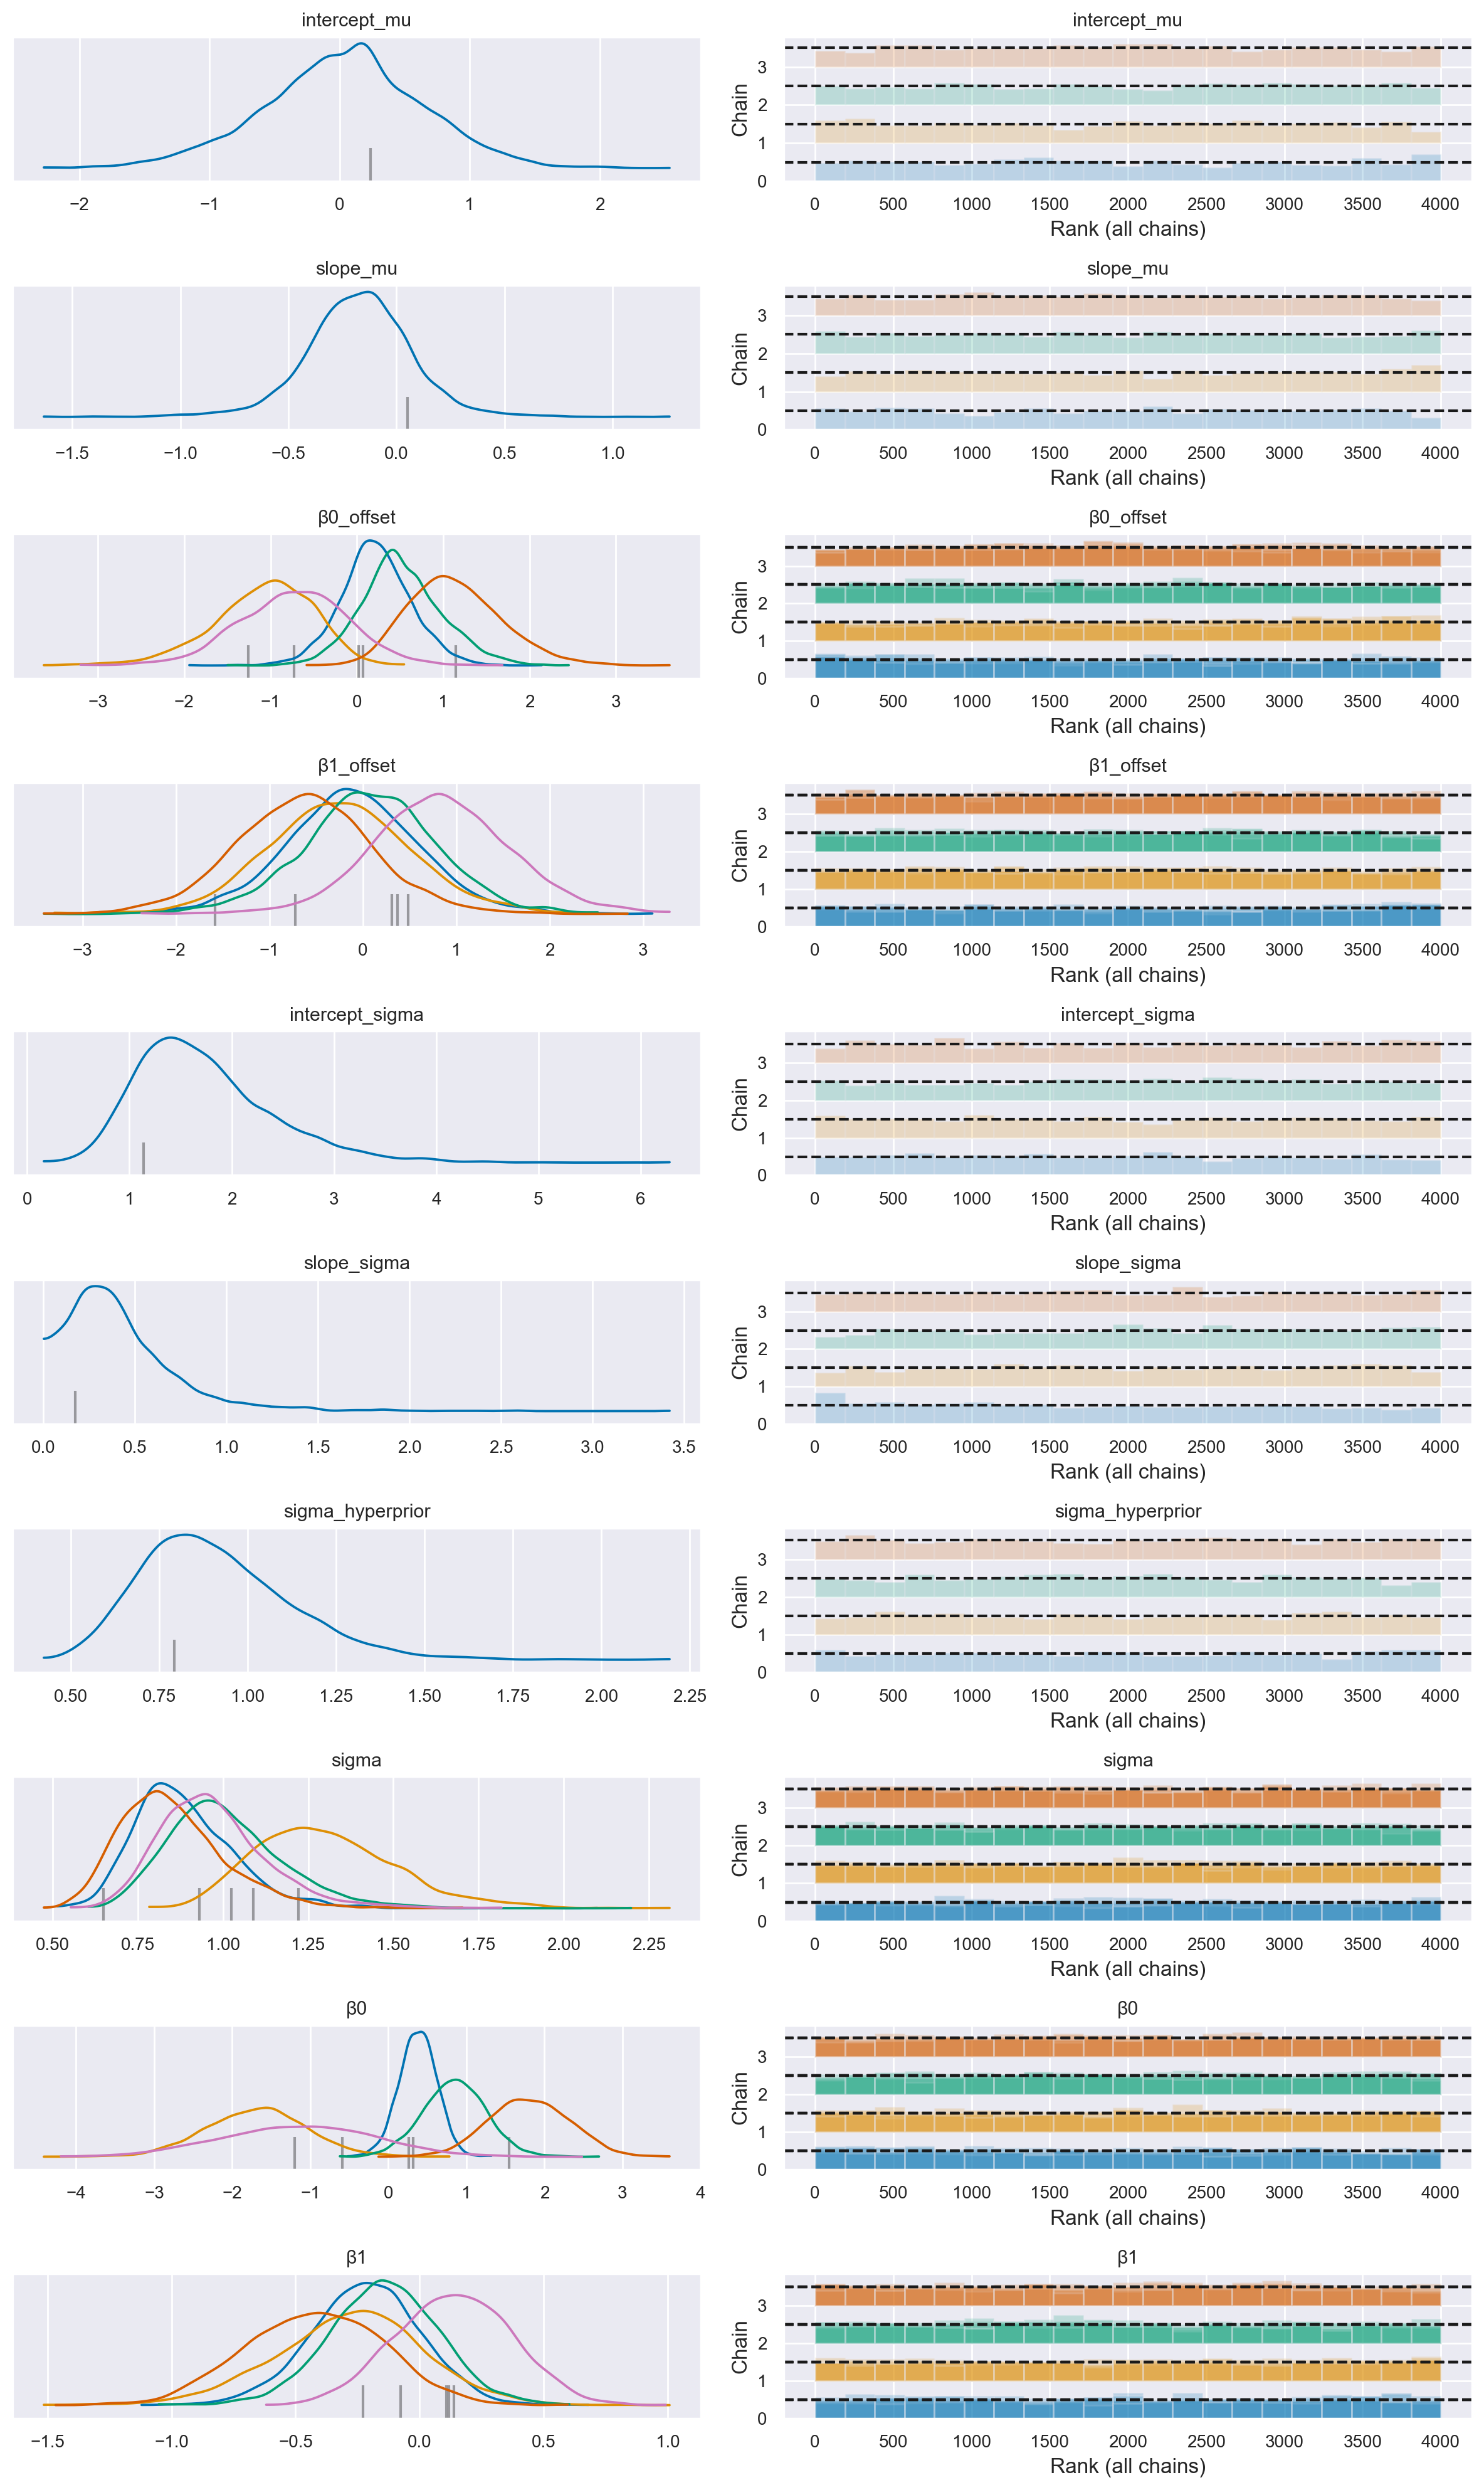

In [31]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

In [32]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with hierarchical:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"]))

Sampling: [y]


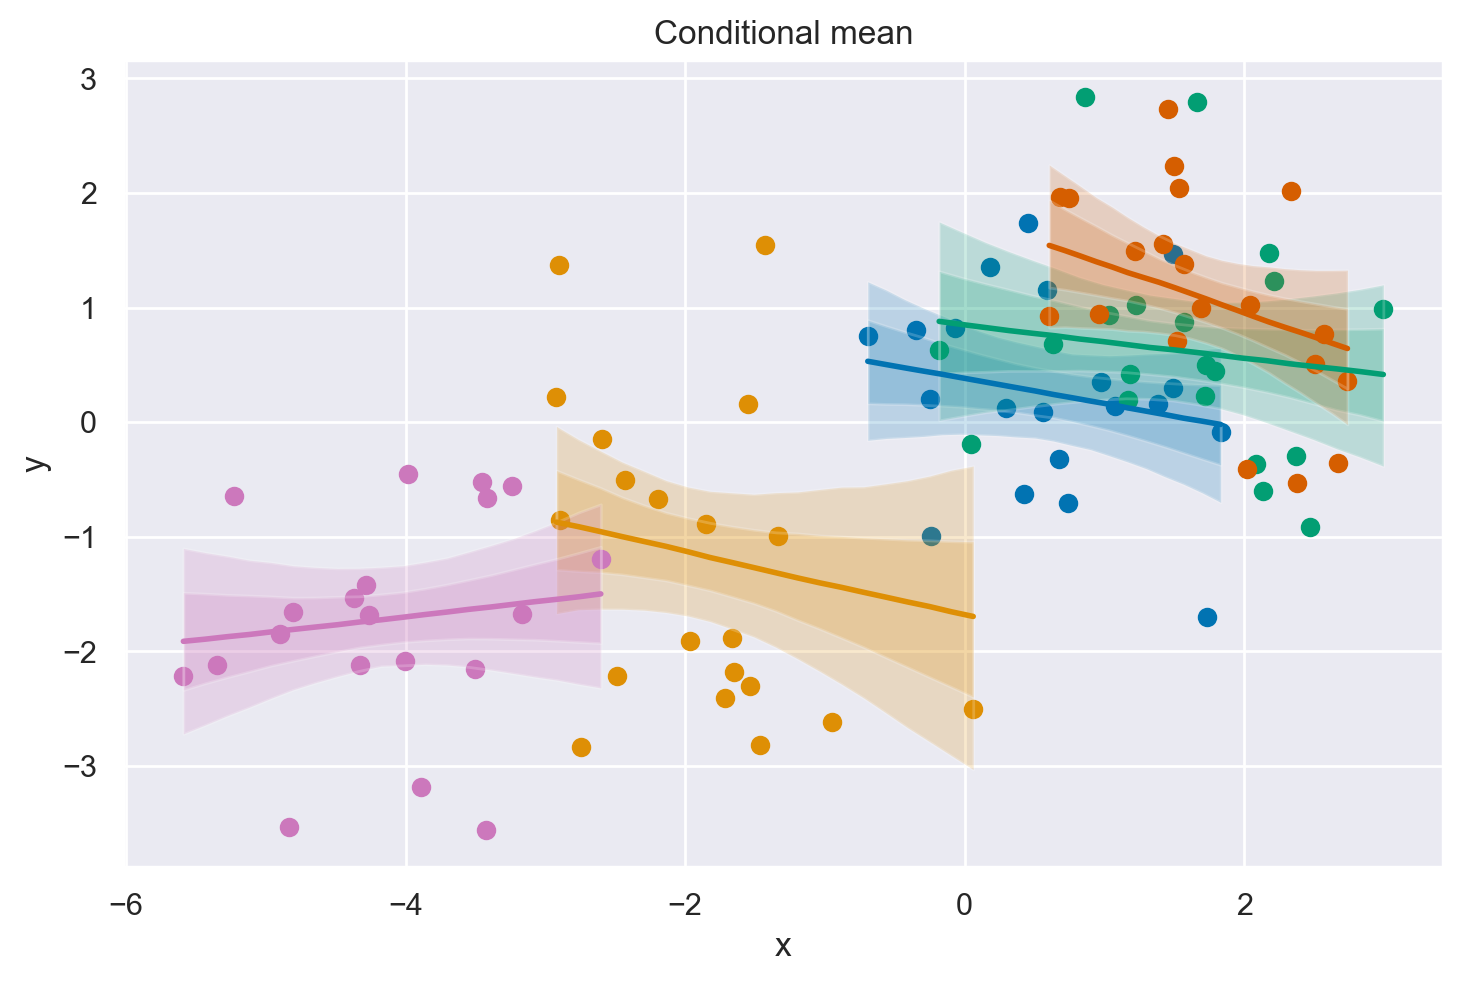

In [33]:
fig, ax = plt.subplots(1, 1)

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax.scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax.fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax.fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax.plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax.set(xlabel="x", ylabel="y", title="Conditional mean")


In [34]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

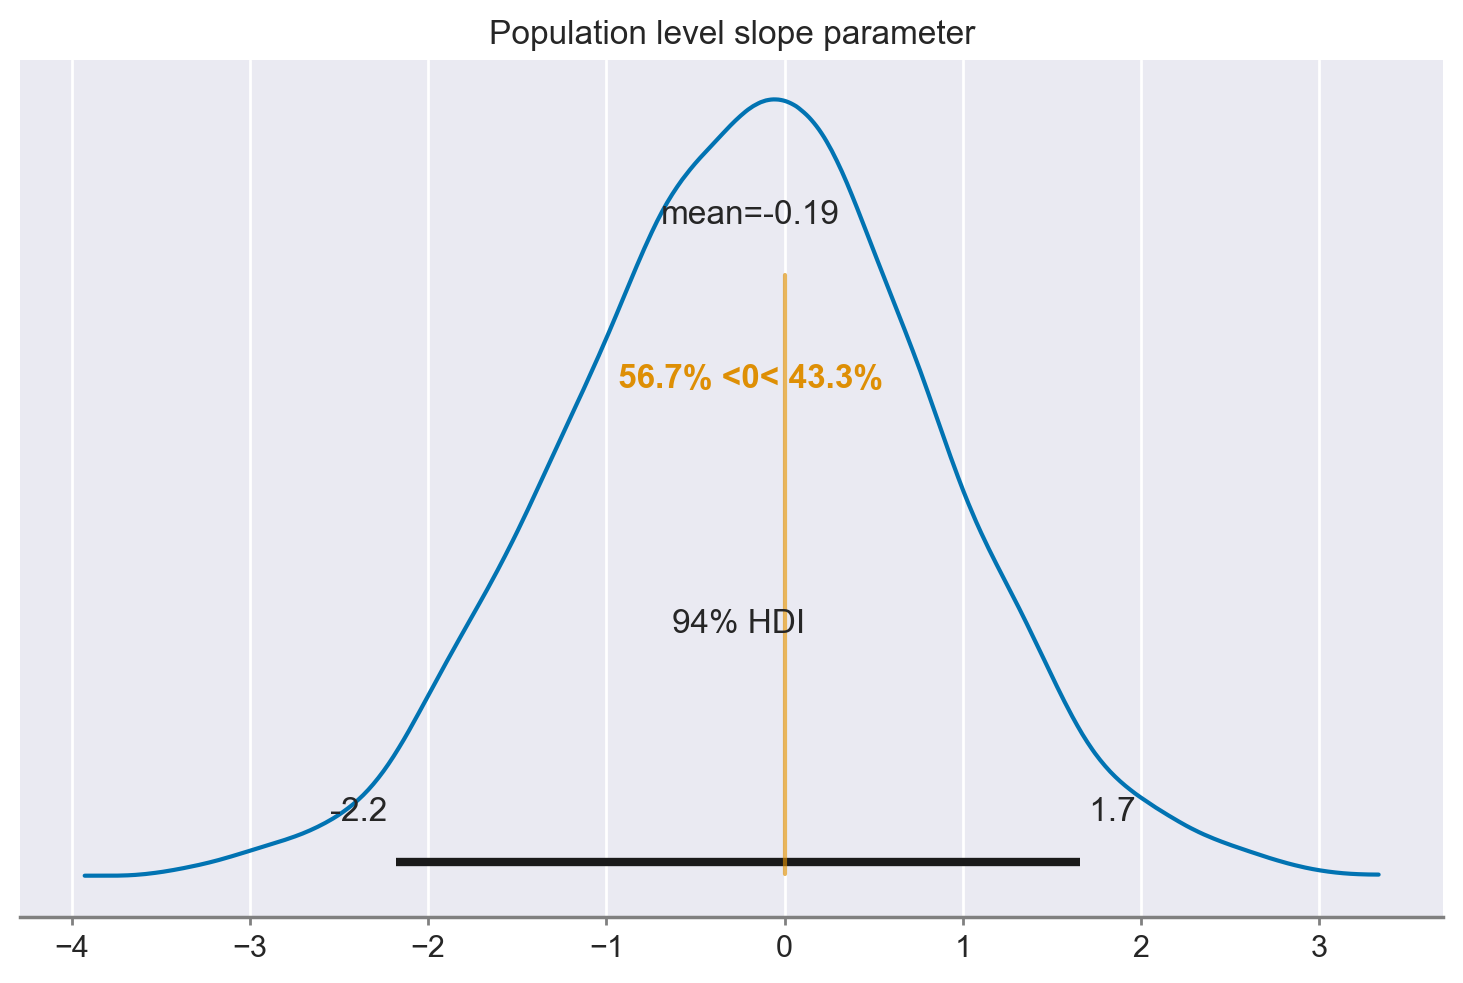

In [35]:
# plot posterior for population level slope
slope = rng.normal(az.extract(idata.posterior, var_names="slope_mu"))
az.plot_posterior(slope, ref_val=0)
_ = plt.title("Population level slope parameter")

In [36]:
%run ../wm.py

Watermark:
----------
Last updated: 2024-01-26T19:05:23.650478+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


